In [49]:
import os
import matplotlib.pyplot as plt
import jax.numpy as jnp 
import jax 
import equinox as eqx
import optax

In [121]:
IMAGE_SIZE = 64
BATCH_SIZE = 16
BATCH_COUNT = 32
LATENT_DIMS = 64
T = 1000

# Data Preparation

In [122]:

def load_data(path : str, count : int):
    """Load images from a directory."""
    images = []
    i = 0
    for file in os.listdir(path):
        i += 1
        if i > count:
            break
        if file.endswith(".jpg"):
            images.append(plt.imread(os.path.join(path, file)))

    return images


In [123]:
def make_batches(images : jnp.ndarray, batch_size : int, batch_count : int, size : int):
    """Reshape images into batches."""
    batches = images.reshape((batch_count, batch_size, size, size, 3))
    batches = jnp.transpose(batches, (0, 1, 4, 2, 3))
    batches = batches / 255.0
    return batches


In [124]:
images = load_data("data_processed", 512)
images = jnp.array(images)

batches = make_batches(images, batch_size=BATCH_SIZE, batch_count=BATCH_COUNT, size=IMAGE_SIZE)

print(f"Loaded images result shape: {batches.shape}")
print(f"That is {BATCH_COUNT} batches of {BATCH_SIZE} images of size {IMAGE_SIZE}x{IMAGE_SIZE}x3")
print(f"Image range: {jnp.min(batches)} to {jnp.max(batches)} with mean {jnp.mean(batches)}")

Loaded images result shape: (32, 16, 3, 64, 64)
That is 32 batches of 16 images of size 64x64x3
Image range: 0.0 to 0.9999999403953552 with mean 0.4687947630882263


In [125]:
def generate_alphas(T : int, beta : float = 0.02):
    """Generate alpha and beta schedules for diffusion process."""
    betas = jnp.linspace(beta, 0.2, T)
    alphas = 1 - betas
    alphas_cumprod = jnp.cumprod(alphas)
    return alphas, alphas_cumprod, betas

In [126]:
def batch_noise(
        xs : jnp.ndarray, 
        key : jax.random.PRNGKey,
        alphas_cumprod : jnp.ndarray,
        T : int = 100,
        batch_size : int = BATCH_SIZE
    ):
    """Add noise to a batch of images according to the diffusion schedule."""

    ts = jax.random.randint(key, (batch_size,), minval=1, maxval=T + 1)

    eps = jax.random.normal(key, xs.shape)

    sqrt_alphas_cumprod = jnp.sqrt(alphas_cumprod.at[ts].get())
    sqrt_one_minus_alphas_cumprod = jnp.sqrt(1 - alphas_cumprod.at[ts].get())

    xs_noisy = sqrt_alphas_cumprod[:, None, None, None] * xs + sqrt_one_minus_alphas_cumprod[:, None, None, None] * eps

    return xs_noisy, eps, ts

In [127]:
alphas, alphas_cumprod, betas = generate_alphas(T)
key = jax.random.PRNGKey(0)
batch_noisy, batch_eps, batch_ts = batch_noise(batches[0], key, alphas_cumprod, T, BATCH_SIZE)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-3.955557..3.6111305].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.559669..1.2956456].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-3.5719352..3.604516].


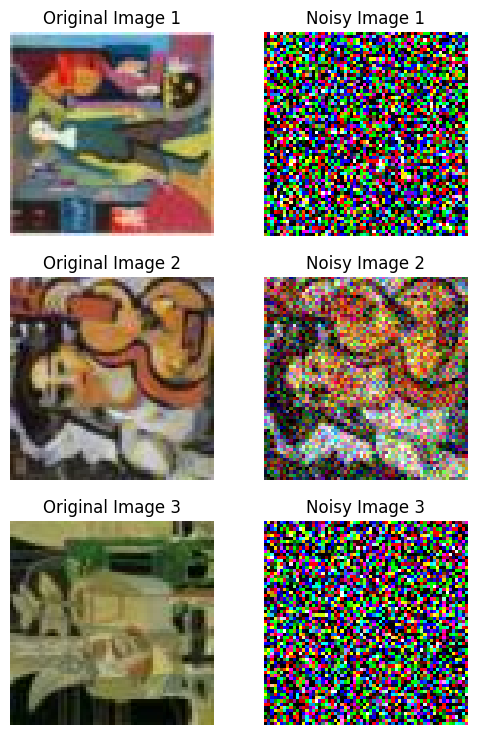

In [128]:
fig, axs = plt.subplots(3, 2, figsize=(6, 9))

for i in range(3):
    axs[i, 1].imshow(jnp.swapaxes(batch_noisy[i], 0, 2))
    axs[i, 1].set_title(f"Noisy Image {i+1}")

    axs[i, 0].imshow(jnp.swapaxes(batches[0, i], 0, 2))
    axs[i, 0].set_title(f"Original Image {i+1}")

    axs[i, 1].axis('off')
    axs[i, 0].axis('off')


plt.show()

# Neural Network

In [129]:
NUM_EPOCHS = 100
LEARNING_RATE = 1e-3

In [ ]:
class DiffusionTransformer(eqx.Module):
    """A simple transformer model for diffusion."""

    encode_conv : eqx.nn.Conv2d
    encode_mlp : eqx.nn.Linear

    conditioning : eqx.nn.Linear
    multihead_attn : eqx.nn.MultiheadAttention
    
    def __init__(
        self, 
        in_shape : tuple,
        out_shape : tuple,
        num_attention_heads : int,
        key : jax.random.PRNGKey):
        
        key1, key2 = jax.random.split(key, 2)

        self.encode_conv = eqx.nn.Conv2d(
            in_channels=in_shape[0], 
            out_channels=16,
            kernel_size=3, 
            padding=1, 
            key=key1)
        
        
        self.conditioning = eqx.nn.Linear(
            in_features=latent_dims + 1, 
            out_features=latent_dims, 
            key=key2)
        
        self.multihead_attn = eqx.nn.MultiheadAttention(
            num_heads = num_attention_heads,
            query_size = latent_dims,
        


    def __call__(
        self, 
        x : jnp.ndarray,
        t : jnp.ndarray,
        label : jnp.ndarray = None) -> jnp.ndarray:

        latent = self.encode(x)

        parameters = jnp.concatenate([latent.flatten(), t])

        conditioning 




In [ ]:
class Denoiser(eqx.Module):
    conv1 : eqx.nn.Conv2d
    conv2 : eqx.nn.Conv2d
    conv3 : eqx.nn.Conv2d
    conv4 : eqx.nn.Conv2d

    def __init__(
            self, 
            key : jax.random.PRNGKey,
            in_shape=(4, IMAGE_SIZE, IMAGE_SIZE),
            latent_dims=LATENT_DIMS,
            out_shape=(3, IMAGE_SIZE, IMAGE_SIZE)):
        
        key1, key2, key3, key4 = jax.random.split(key, 4)
        self.conv1 = eqx.nn.Conv2d(in_shape[0], latent_dims, kernel_size=3, padding=1, key=key1)
        self.conv2 = eqx.nn.Conv2d(latent_dims, latent_dims, kernel_size=3, padding=1, key=key2)
        self.conv3 = eqx.nn.Conv2d(latent_dims, latent_dims, kernel_size=3, padding=1, key=key3)
        self.conv4 = eqx.nn.Conv2d(latent_dims, out_shape[0], kernel_size=3, padding=1, key=key4)

    def __call__(self, x, t):
        t = jnp.ones((1, x.shape[1], x.shape[2])) * t

        x = jnp.concatenate([x, t], axis=0)  # Concatenat   e time embedding
        x = jax.nn.relu(self.conv1(x))
        x = jax.nn.relu(self.conv2(x))
        x = jax.nn.relu(self.conv3(x))
        x = self.conv4(x)
        return x

In [131]:
denoiser = Denoiser(
    in_shape=(4, IMAGE_SIZE, IMAGE_SIZE), 
    latent_dims=128, 
    out_shape=(3, IMAGE_SIZE, IMAGE_SIZE), 
    key=jax.random.PRNGKey(1312)
)

# Training

In [132]:
def loss_fn(model, x0, t, eps):
    """Compute the loss for a batch of images."""
    pred_eps = jax.vmap(model)(x0, t)

    return jnp.mean((pred_eps - eps) ** 2)

In [133]:
optim = optax.adamw(LEARNING_RATE)

def train(
    model : Denoiser,
    optim : optax.GradientTransformation,
    batches : jnp.ndarray = batches,
    num_epochs : int = NUM_EPOCHS,
    key : jax.random.PRNGKey = jax.random.PRNGKey(0)):
    """Train the denoising model."""

    opt_state = optim.init(eqx.filter(model, eqx.is_array))

    @eqx.filter_jit
    def make_step(model, opt_state, x0, t, eps):
        loss_value, grads = eqx.filter_value_and_grad(loss_fn)(model, x0, t, eps)
        updates, opt_state = optim.update(
            eqx.filter(grads, eqx.is_array), 
            opt_state, 
            eqx.filter(model, eqx.is_array)
        )
        model = eqx.apply_updates(model, updates)
        return model, opt_state, loss_value
    

    for epoch in range(num_epochs):
        epoch_loss = 0.0
        for batch in batches:
            key, subkey = jax.random.split(key)
            x0 = batch
            x_noisy, eps, ts = batch_noise(x0, subkey, alphas_cumprod, T, BATCH_SIZE)
            model, opt_state, loss_value = make_step(model, opt_state, x_noisy, ts, eps)
            epoch_loss += loss_value

        epoch_loss /= len(batches)
        if epoch % 10 == 0:
            print(f"Epoch {epoch}, Loss: {epoch_loss}")


In [134]:
train(denoiser, optim, batches, NUM_EPOCHS, jax.random.PRNGKey(0))

Epoch 0, Loss: 385.87860107421875
Epoch 10, Loss: 0.8105445504188538
Epoch 20, Loss: 0.5680869817733765
Epoch 30, Loss: 0.39767855405807495
Epoch 40, Loss: 0.21946656703948975
Epoch 50, Loss: 0.15268364548683167
Epoch 60, Loss: 0.0650242269039154
Epoch 70, Loss: 0.05952397733926773
Epoch 80, Loss: 0.04043000936508179
Epoch 90, Loss: 0.05298318341374397


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-3.955557..3.6111305].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.559669..1.2956456].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-3.5719352..3.604516].


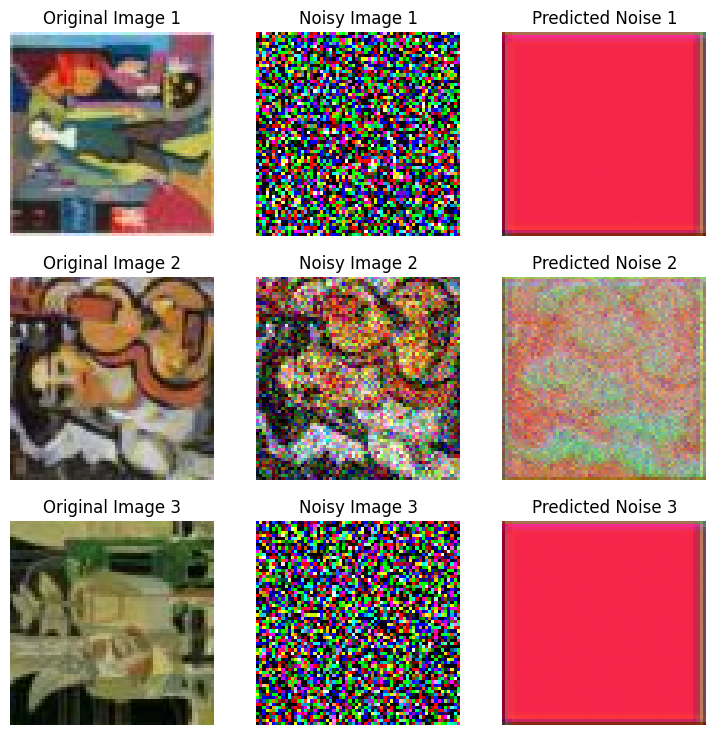

In [136]:
# lets investigate some of the noise and predicted noise
fig, axs = plt.subplots(3, 3, figsize=(9, 9))
for i in range(3):
    axs[i, 0].imshow(jnp.swapaxes(batches[0, i], 0, 2))
    axs[i, 0].set_title(f"Original Image {i+1}")
    axs[i, 0].axis('off')

    axs[i, 1].imshow(jnp.swapaxes(batch_noisy[i], 0, 2))
    axs[i, 1].set_title(f"Noisy Image {i+1}")
    axs[i, 1].axis('off')

    pred_eps = denoiser(batch_noisy[i], batch_ts[i])
    axs[i, 2].imshow(jnp.swapaxes((pred_eps - jnp.min(pred_eps)) / (jnp.max(pred_eps) - jnp.min(pred_eps)), 0, 2))
    axs[i, 2].set_title(f"Predicted Noise {i+1}")
    axs[i, 2].axis('off')

# Inference

In [137]:
def generate_image(
    model : Denoiser,
    alphas : jnp.ndarray = alphas,
    alphas_cumprod : jnp.ndarray = alphas_cumprod,
    betas : jnp.ndarray = betas,
    T : int = T,
    img_size : int = IMAGE_SIZE,
    key : jax.random.PRNGKey = jax.random.PRNGKey(42)
):
    """Generate an image by reversing the diffusion process."""
    key, subkey = jax.random.split(key)
    x = jax.random.normal(subkey, (1, 3, img_size, img_size))

    for t in reversed(range(1, T + 1)):

        t_array = jnp.array([t])
        pred_eps = model(x[0], t_array)

        alpha_t = alphas[t - 1]
        alpha_cumprod_t = alphas_cumprod[t - 1]
        beta_t = betas[t - 1]

        coef = beta_t / jnp.sqrt(1 - alpha_cumprod_t)
        x = (1 / jnp.sqrt(alpha_t)) * (x - coef * pred_eps)

        if t > 1:
            sigma_t = jnp.sqrt(beta_t)
            key, subkey = jax.random.split(key)
            z = jax.random.normal(subkey, x.shape)
            x += sigma_t * z

    x = jnp.clip(x, 0.0, 1.0)
    return x[0]

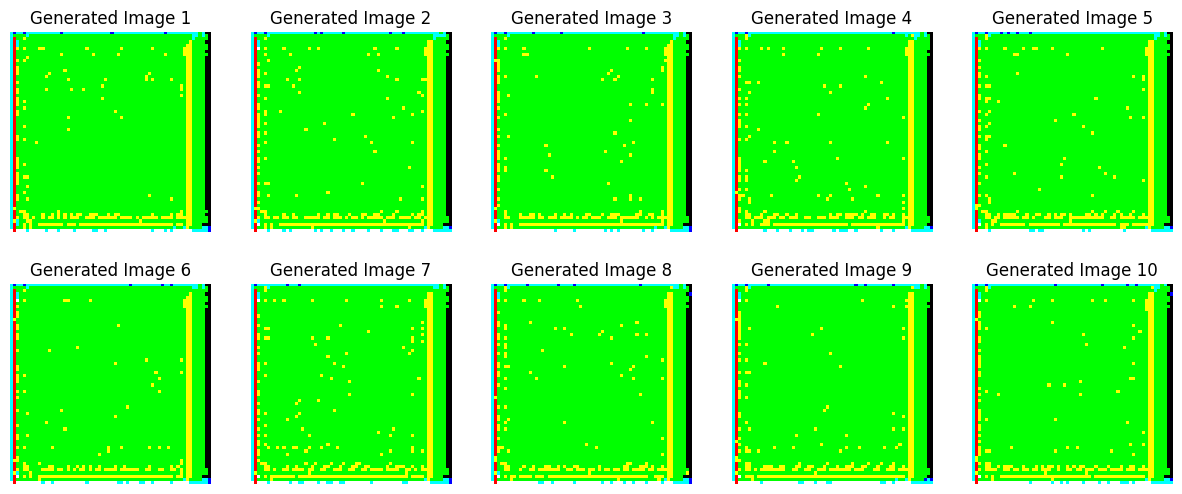

In [138]:
fig, axs = plt.subplots(2, 5, figsize=(15, 6))
for i in range(10):
    key, subkey = jax.random.split(key)
    generated_img = generate_image(denoiser, key=subkey)
    axs[i // 5, i % 5].imshow(jnp.swapaxes(generated_img, 0, 2))
    axs[i // 5, i % 5].axis('off')
    axs[i // 5, i % 5].set_title(f"Generated Image {i+1}")
plt.show()